### 1. 실험환경 확인

In [1]:
import torch

# GPU를 사용할 수 있는지 확인
if torch.cuda.is_available():
    # 사용 가능한 GPU 디바이스 개수 확인
    num_gpu = torch.cuda.device_count()
    print(f"사용 가능한 GPU 수: {num_gpu}")

    # 현재 선택된 GPU 디바이스 확인
    current_gpu = torch.cuda.current_device()
    print(f"현재 선택된 GPU: {current_gpu}")

    # 사용 가능한 GPU 디바이스 목록 확인
    for i in range(num_gpu):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU를 사용할 수 없습니다.")


사용 가능한 GPU 수: 1
현재 선택된 GPU: 0
GPU 0: GeForce GTX 1060 6GB


c:\Users\user\anaconda3\envs\test_RL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !pip install opencv-python
# !pip install gym[all,accept-rom-license]
# !pip install swig
# !pip install --upgrade pip setuptools wheel
# !pip install --upgrade gym
# !pip install tqdm
# !pip install gym[box2d]
# !pip install pyvirtualdisplay moviepy
# !pip install pandas

### 1-1 라이브러리 import

In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt
import pandas as pd
import time

In [6]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# GPU 사용 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}, state : {state_size}, action : {action_size}")

cuda, state : 8, action : 4


### 1-2. seed number 변경 세팅

In [9]:
seed = 30
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 2. Policy network 설정

In [4]:
#%% Policy network  - hidden layer 변경하여 실험 진행
class Qnet(nn.Module):

    def __init__(self, n_states, n_actions, n_hidden=128):
        super(Qnet, self).__init__()

        self.fc1 = nn.Linear(n_states, n_hidden)
        #self.fc2 = nn.Linear(n_hidden, n_hidden)
        # self.fc3 = nn.Linear(n_hidden, n_hidden)
        # self.fc4 = nn.Linear(n_hidden, n_hidden)
        self.fc5 = nn.Linear(n_hidden, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x  
    

### 2-1 DQN 설정

In [11]:
class DQN:
    def __init__(self, n_states, n_actions, batch_size, lr, gamma, memory_size, learn_step, tau, device=None):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 가장 좋은 모델 저장을 위한 변수
        self.best_score = float('-inf')  # 초기화: 음수 무한대

        # 모델
        self.net_eval = Qnet(n_states, n_actions).to(device)
        self.net_target = Qnet(n_states, n_actions).to(device)
        self.optimizer = optim.AdamW(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # 메모리
        self.memory = ReplayBuffer(n_actions, memory_size, batch_size)
        self.counter = 0    # 업데이트 주기 카운터

        # 에피소드당 평균 보상을 기록할 리스트 초기화
        self.avg_score_hist = []

        # 총 보상을 기록할 리스트 초기화
        self.score_hist = []

    def sample_action(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.net_eval.eval()
        coin = random.random()

        with torch.no_grad():
            action_values_eval = self.net_eval(state)

        if coin < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            # Use net_eval for action selection and net_target for action evaluation
            action = np.argmax(self.net_target(state).cpu().data.numpy())

        self.net_eval.train()
        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.put(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones)  # target, if terminal then y_j = rewards

        # 추가 부분
        actions = actions.to(torch.int64)
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network
        self.soft_update()

    def soft_update(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

    def train(self, env, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, chkpt=False):

        epsilon = eps_start
        start_time = time.time()
        epsilon = eps_start

        # Calculate decay factor based on the given eps_decay and number of episodes
        decay_factor = np.exp(np.log(eps_end / eps_start) / n_episodes)

        for idx_epi in tqdm(range(n_episodes), unit="ep", ascii=True):
            state = env.reset()[0]
            score = 0

            for idx_step in range(max_steps):
                action = self.sample_action(state, epsilon)
                next_state, reward, done, _, _ = env.step(action)
                self.save2memory(state, action, reward, next_state, done)
                state = next_state
                score += reward

                if done:
                    break

            experiences = self.memory.sample()
            self.learn(experiences)

            self.score_hist.append(score)
            score_avg = np.mean(self.score_hist[-100:])
            epsilon = max(eps_end, epsilon * decay_factor)  # Update epsilon using decay factor

            self.avg_score_hist.append(score_avg)

            if (idx_epi + 1) % 50 == 0:
                elapsed_time = time.time() - start_time  # 현재까지 걸린 시간 계산
                print(f"Episode {idx_epi + 1}, Score: {score:.3f}, Avg Score (last 100): {score_avg:.3f}, Epsilon: {epsilon:.3f}, Elapsed Time: {elapsed_time:.2f} seconds")

                if score > self.best_score:
                    self.best_score = score
                    print("====Saving the best model====")
                    torch.save(self.net_eval.state_dict(), 'best_model_DQN_1_layer_seed30.pth')

        if idx_epi == n_episodes - 1:
            print("\nDone!")

        self.save_scores_to_csv()

        return self.score_hist, self.avg_score_hist


    def soft_update(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

    def load_model(self, path):
        self.net_eval.load_state_dict(torch.load(path))
        self.net_eval.eval()

    def save_scores_to_csv(self, filename='scores_DQN_1_layer_seed30.csv'):
        df = pd.DataFrame({'Episode': np.arange(1, len(self.score_hist) + 1), 'Score': self.score_hist, 'Avg_Score': self.avg_score_hist})
        df.to_csv(filename, index=False)


### 2-2 ReplayBuffer 설정

In [12]:
class ReplayBuffer:
    def __init__(self, n_actions, memory_size, batch_size, device=None):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory = collections.deque(maxlen=memory_size)

    def put(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        self.memory.append(transition)

    def sample(self):
        mini_batch = random.sample(self.memory, self.batch_size)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return (
            torch.tensor(s_lst, dtype=torch.float, device=self.device),
            torch.tensor(a_lst, device=self.device),
            torch.tensor(r_lst, dtype=torch.float, device=self.device),
            torch.tensor(s_prime_lst, dtype=torch.float, device=self.device),
            torch.tensor(done_mask_lst, dtype=torch.float, device=self.device)
        )

    def __len__(self):
        return len(self.memory)

### 2-3 plot 함수 정의

In [13]:
def plot_score(scores, moving_avg_scores, save_path=None):
    plt.figure(figsize=(15, 4))
    
    # Plot Episode Score
    plt.plot(scores, label='Episode Score')
    
    # Plot Moving Average Score
    plt.plot(moving_avg_scores, label='Moving Average Score', color='r', linestyle='--')

    # Plot Overall Mean Score
    overall_mean_score = np.mean(scores)
    plt.axhline(y=overall_mean_score, color='g', linestyle='-.', label=f'Overall Mean Score: {overall_mean_score:.2f}')

    # Find and Plot Maximum Score
    max_score = np.max(scores)
    plt.scatter(np.argmax(scores), max_score, color='m', label=f'Max Score: {max_score:.2f}', marker='o', s=100)

    # Plot Standard Deviation
    std_dev_score = np.std(moving_avg_scores)
    plt.title(f"Scores Over Episodes - Standard Deviation: {std_dev_score:.2f}")

    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.legend()

    # Save the plot to an image file if save_path is provided
    if save_path:
        plt.savefig(save_path)
    
    # Show the plot (either in a window or saved file)
    plt.show()

### 3. 하이퍼파라미터 설정

In [14]:
batch_size = 32
lr = 1e-3
episode = 10000
gamma = 0.999            # discount factor
memory_size = 10000     # max memory buffer size
learn_step = 5          # how often to learn
tau = 1e-4              # for soft update of target parameters
print(device)

cuda


### 4. 실험 진행 / 저장

In [17]:
env = gym.make('LunarLander-v2')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

agent = DQN(
    n_states=num_states,
    n_actions=num_actions,
    batch_size=batch_size,
    lr=lr,
    gamma=gamma,
    memory_size=memory_size,
    learn_step=learn_step,
    tau=tau,
    device=device
)

score_hist, avg_score_hist = agent.train(env, n_episodes=episode)


  1%|          | 52/10000 [00:04<12:42, 13.04ep/s]

Episode 50, Score: -78.978, Avg Score (last 100): -200.673, Epsilon: 0.977, Elapsed Time: 4.13 seconds
====Saving the best model====


  1%|1         | 102/10000 [00:08<12:40, 13.02ep/s]

Episode 100, Score: -176.921, Avg Score (last 100): -186.199, Epsilon: 0.955, Elapsed Time: 7.88 seconds


  2%|1         | 152/10000 [00:12<13:59, 11.73ep/s]

Episode 150, Score: -116.644, Avg Score (last 100): -177.712, Epsilon: 0.933, Elapsed Time: 12.04 seconds


  2%|2         | 202/10000 [00:16<13:19, 12.25ep/s]

Episode 200, Score: -122.867, Avg Score (last 100): -161.974, Epsilon: 0.912, Elapsed Time: 16.11 seconds


  3%|2         | 252/10000 [00:20<14:34, 11.15ep/s]

Episode 250, Score: -153.986, Avg Score (last 100): -144.806, Epsilon: 0.891, Elapsed Time: 20.23 seconds


  3%|3         | 302/10000 [00:24<13:11, 12.25ep/s]

Episode 300, Score: -125.253, Avg Score (last 100): -139.909, Epsilon: 0.871, Elapsed Time: 24.50 seconds


  4%|3         | 352/10000 [00:29<14:53, 10.80ep/s]

Episode 350, Score: -78.317, Avg Score (last 100): -138.058, Epsilon: 0.851, Elapsed Time: 29.10 seconds
====Saving the best model====


  4%|4         | 402/10000 [00:33<13:30, 11.84ep/s]

Episode 400, Score: -253.063, Avg Score (last 100): -146.618, Epsilon: 0.832, Elapsed Time: 33.84 seconds


  5%|4         | 452/10000 [00:38<13:38, 11.66ep/s]

Episode 450, Score: -66.232, Avg Score (last 100): -151.748, Epsilon: 0.813, Elapsed Time: 38.46 seconds
====Saving the best model====


  5%|5         | 501/10000 [00:43<15:09, 10.44ep/s]

Episode 500, Score: -111.436, Avg Score (last 100): -138.456, Epsilon: 0.794, Elapsed Time: 43.40 seconds


  6%|5         | 551/10000 [00:48<17:33,  8.97ep/s]

Episode 550, Score: -93.571, Avg Score (last 100): -132.734, Epsilon: 0.776, Elapsed Time: 48.55 seconds


  6%|6         | 601/10000 [00:53<17:21,  9.02ep/s]

Episode 600, Score: -188.367, Avg Score (last 100): -157.183, Epsilon: 0.759, Elapsed Time: 53.79 seconds


  7%|6         | 651/10000 [00:59<15:38,  9.96ep/s]

Episode 650, Score: -43.829, Avg Score (last 100): -163.822, Epsilon: 0.741, Elapsed Time: 59.18 seconds
====Saving the best model====


  7%|7         | 700/10000 [01:04<19:53,  7.79ep/s]

Episode 700, Score: -190.087, Avg Score (last 100): -152.050, Epsilon: 0.724, Elapsed Time: 64.75 seconds


  8%|7         | 751/10000 [01:10<15:46,  9.78ep/s]

Episode 750, Score: -56.485, Avg Score (last 100): -129.480, Epsilon: 0.708, Elapsed Time: 70.68 seconds


  8%|8         | 800/10000 [01:16<22:54,  6.69ep/s]

Episode 800, Score: -167.939, Avg Score (last 100): -114.773, Epsilon: 0.692, Elapsed Time: 76.89 seconds


  9%|8         | 851/10000 [01:23<16:18,  9.35ep/s]

Episode 850, Score: -98.137, Avg Score (last 100): -119.880, Epsilon: 0.676, Elapsed Time: 83.08 seconds


  9%|9         | 900/10000 [01:29<18:04,  8.39ep/s]

Episode 900, Score: -262.554, Avg Score (last 100): -127.578, Epsilon: 0.661, Elapsed Time: 89.26 seconds


 10%|9         | 951/10000 [01:35<18:45,  8.04ep/s]

Episode 950, Score: -174.994, Avg Score (last 100): -131.988, Epsilon: 0.646, Elapsed Time: 95.12 seconds


 10%|#         | 1001/10000 [01:41<21:04,  7.12ep/s]

Episode 1000, Score: -222.729, Avg Score (last 100): -132.405, Epsilon: 0.631, Elapsed Time: 101.14 seconds


 11%|#         | 1051/10000 [01:47<21:00,  7.10ep/s]

Episode 1050, Score: -168.558, Avg Score (last 100): -129.682, Epsilon: 0.617, Elapsed Time: 107.47 seconds


 11%|#1        | 1101/10000 [01:54<17:57,  8.26ep/s]

Episode 1100, Score: -54.662, Avg Score (last 100): -123.227, Epsilon: 0.603, Elapsed Time: 114.48 seconds


 12%|#1        | 1151/10000 [02:01<17:53,  8.25ep/s]

Episode 1150, Score: -96.131, Avg Score (last 100): -112.339, Epsilon: 0.589, Elapsed Time: 121.55 seconds


 12%|#2        | 1201/10000 [02:09<19:53,  7.37ep/s]

Episode 1200, Score: -67.666, Avg Score (last 100): -107.907, Epsilon: 0.575, Elapsed Time: 129.86 seconds


 13%|#2        | 1251/10000 [02:17<23:36,  6.18ep/s]

Episode 1250, Score: -141.591, Avg Score (last 100): -106.574, Epsilon: 0.562, Elapsed Time: 137.29 seconds


 13%|#3        | 1301/10000 [02:25<22:29,  6.45ep/s]

Episode 1300, Score: -112.341, Avg Score (last 100): -107.625, Epsilon: 0.550, Elapsed Time: 145.66 seconds


 14%|#3        | 1351/10000 [02:35<24:26,  5.90ep/s]

Episode 1350, Score: -61.968, Avg Score (last 100): -112.728, Epsilon: 0.537, Elapsed Time: 154.89 seconds


 14%|#4        | 1401/10000 [02:46<20:16,  7.07ep/s]  

Episode 1400, Score: -42.793, Avg Score (last 100): -105.466, Epsilon: 0.525, Elapsed Time: 166.55 seconds
====Saving the best model====


 15%|#4        | 1451/10000 [02:56<20:57,  6.80ep/s]  

Episode 1450, Score: -112.413, Avg Score (last 100): -92.326, Epsilon: 0.513, Elapsed Time: 176.26 seconds


 15%|#5        | 1500/10000 [03:10<20:28,  6.92ep/s]  

Episode 1500, Score: -50.131, Avg Score (last 100): -89.140, Epsilon: 0.501, Elapsed Time: 190.94 seconds


 16%|#5        | 1551/10000 [03:28<35:49,  3.93ep/s]  

Episode 1550, Score: -286.438, Avg Score (last 100): -93.141, Epsilon: 0.490, Elapsed Time: 208.09 seconds


 16%|#6        | 1601/10000 [03:40<22:37,  6.19ep/s]  

Episode 1600, Score: -209.620, Avg Score (last 100): -95.801, Epsilon: 0.479, Elapsed Time: 220.80 seconds


 17%|#6        | 1651/10000 [03:58<23:05,  6.03ep/s]  

Episode 1650, Score: -205.911, Avg Score (last 100): -79.851, Epsilon: 0.468, Elapsed Time: 238.68 seconds


 17%|#7        | 1700/10000 [04:17<1:27:57,  1.57ep/s]

Episode 1700, Score: 37.678, Avg Score (last 100): -70.035, Epsilon: 0.457, Elapsed Time: 257.13 seconds
====Saving the best model====


 18%|#7        | 1751/10000 [04:34<32:07,  4.28ep/s]  

Episode 1750, Score: -232.314, Avg Score (last 100): -76.477, Epsilon: 0.447, Elapsed Time: 274.15 seconds


 18%|#7        | 1799/10000 [05:07<1:40:24,  1.36ep/s]

Episode 1800, Score: -64.856, Avg Score (last 100): -49.319, Epsilon: 0.437, Elapsed Time: 307.36 seconds


 19%|#8        | 1851/10000 [05:30<24:27,  5.55ep/s]  

Episode 1850, Score: -127.364, Avg Score (last 100): -34.766, Epsilon: 0.427, Elapsed Time: 330.12 seconds


 19%|#9        | 1901/10000 [05:56<43:22,  3.11ep/s]  

Episode 1900, Score: -50.120, Avg Score (last 100): -37.875, Epsilon: 0.417, Elapsed Time: 356.05 seconds


 20%|#9        | 1951/10000 [06:18<31:00,  4.33ep/s]  

Episode 1950, Score: -44.918, Avg Score (last 100): -37.645, Epsilon: 0.407, Elapsed Time: 378.55 seconds


 20%|##        | 2000/10000 [06:36<26:13,  5.09ep/s]  

Episode 2000, Score: 83.557, Avg Score (last 100): -50.997, Epsilon: 0.398, Elapsed Time: 396.70 seconds
====Saving the best model====


 20%|##        | 2050/10000 [07:06<29:57,  4.42ep/s]  

Episode 2050, Score: -36.593, Avg Score (last 100): -51.466, Epsilon: 0.389, Elapsed Time: 426.08 seconds


 21%|##1       | 2100/10000 [07:32<58:42,  2.24ep/s]  

Episode 2100, Score: -49.303, Avg Score (last 100): -50.556, Epsilon: 0.380, Elapsed Time: 452.12 seconds


 22%|##1       | 2150/10000 [08:12<53:53,  2.43ep/s]  

Episode 2150, Score: -35.318, Avg Score (last 100): -59.960, Epsilon: 0.372, Elapsed Time: 492.37 seconds


 22%|##2       | 2200/10000 [08:51<2:08:51,  1.01ep/s]

Episode 2200, Score: -52.096, Avg Score (last 100): -70.708, Epsilon: 0.363, Elapsed Time: 531.14 seconds


 23%|##2       | 2251/10000 [09:31<43:42,  2.96ep/s]  

Episode 2250, Score: -12.631, Avg Score (last 100): -66.148, Epsilon: 0.355, Elapsed Time: 571.27 seconds


 23%|##3       | 2301/10000 [10:25<1:01:07,  2.10ep/s]

Episode 2300, Score: -60.333, Avg Score (last 100): -62.195, Epsilon: 0.347, Elapsed Time: 625.11 seconds


 24%|##3       | 2350/10000 [11:06<1:34:36,  1.35ep/s]

Episode 2350, Score: -27.681, Avg Score (last 100): -67.689, Epsilon: 0.339, Elapsed Time: 666.74 seconds


 24%|##4       | 2401/10000 [11:57<1:09:13,  1.83ep/s]

Episode 2400, Score: 13.045, Avg Score (last 100): -52.801, Epsilon: 0.331, Elapsed Time: 716.98 seconds


 24%|##4       | 2450/10000 [12:48<1:11:22,  1.76ep/s]

Episode 2450, Score: -31.243, Avg Score (last 100): -43.343, Epsilon: 0.324, Elapsed Time: 768.79 seconds


 25%|##5       | 2500/10000 [13:43<1:04:20,  1.94ep/s]

Episode 2500, Score: -43.551, Avg Score (last 100): -42.983, Epsilon: 0.316, Elapsed Time: 823.48 seconds


 26%|##5       | 2550/10000 [14:51<2:47:40,  1.35s/ep]

Episode 2550, Score: -15.630, Avg Score (last 100): -36.352, Epsilon: 0.309, Elapsed Time: 891.35 seconds


 26%|##6       | 2601/10000 [15:47<1:38:18,  1.25ep/s]

Episode 2600, Score: -103.718, Avg Score (last 100): -30.401, Epsilon: 0.302, Elapsed Time: 947.59 seconds


 26%|##6       | 2650/10000 [16:48<3:35:53,  1.76s/ep]

Episode 2650, Score: -116.421, Avg Score (last 100): -36.101, Epsilon: 0.295, Elapsed Time: 1008.28 seconds


 27%|##7       | 2700/10000 [18:05<2:46:14,  1.37s/ep]

Episode 2700, Score: 33.082, Avg Score (last 100): -43.290, Epsilon: 0.288, Elapsed Time: 1085.56 seconds


 28%|##7       | 2750/10000 [19:18<3:24:28,  1.69s/ep]

Episode 2750, Score: -92.228, Avg Score (last 100): -41.031, Epsilon: 0.282, Elapsed Time: 1158.61 seconds


 28%|##8       | 2801/10000 [20:22<2:12:10,  1.10s/ep]

Episode 2800, Score: -142.062, Avg Score (last 100): -37.637, Epsilon: 0.275, Elapsed Time: 1222.50 seconds


 28%|##8       | 2850/10000 [21:31<2:19:30,  1.17s/ep]

Episode 2850, Score: 38.790, Avg Score (last 100): -35.024, Epsilon: 0.269, Elapsed Time: 1291.27 seconds


 29%|##9       | 2900/10000 [22:50<3:51:32,  1.96s/ep]

Episode 2900, Score: 9.537, Avg Score (last 100): -29.504, Epsilon: 0.263, Elapsed Time: 1370.56 seconds


 30%|##9       | 2950/10000 [24:09<3:43:56,  1.91s/ep]

Episode 2950, Score: -63.000, Avg Score (last 100): -22.014, Epsilon: 0.257, Elapsed Time: 1449.08 seconds


 30%|###       | 3000/10000 [25:38<3:46:04,  1.94s/ep]

Episode 3000, Score: -10.472, Avg Score (last 100): -15.330, Epsilon: 0.251, Elapsed Time: 1538.92 seconds


 30%|###       | 3050/10000 [26:55<2:17:28,  1.19s/ep]

Episode 3050, Score: -18.734, Avg Score (last 100): -10.210, Epsilon: 0.245, Elapsed Time: 1615.67 seconds


 31%|###1      | 3100/10000 [28:16<3:18:54,  1.73s/ep]

Episode 3100, Score: -27.126, Avg Score (last 100): -11.346, Epsilon: 0.240, Elapsed Time: 1696.76 seconds


 31%|###1      | 3149/10000 [29:27<2:41:54,  1.42s/ep]

Episode 3150, Score: -51.820, Avg Score (last 100): -14.183, Epsilon: 0.234, Elapsed Time: 1767.09 seconds


 32%|###2      | 3200/10000 [30:36<2:05:31,  1.11s/ep]

Episode 3200, Score: -22.408, Avg Score (last 100): -12.642, Epsilon: 0.229, Elapsed Time: 1836.03 seconds


 33%|###2      | 3251/10000 [31:38<1:55:36,  1.03s/ep]

Episode 3250, Score: 23.332, Avg Score (last 100): -15.444, Epsilon: 0.224, Elapsed Time: 1898.47 seconds


 33%|###3      | 3300/10000 [32:47<2:54:48,  1.57s/ep]

Episode 3300, Score: -19.075, Avg Score (last 100): -25.096, Epsilon: 0.219, Elapsed Time: 1967.05 seconds


 34%|###3      | 3350/10000 [33:58<2:59:18,  1.62s/ep]

Episode 3350, Score: -16.357, Avg Score (last 100): -20.752, Epsilon: 0.214, Elapsed Time: 2038.49 seconds


 34%|###4      | 3400/10000 [35:17<2:31:34,  1.38s/ep]

Episode 3400, Score: -114.176, Avg Score (last 100): -19.553, Epsilon: 0.209, Elapsed Time: 2117.52 seconds


 34%|###4      | 3450/10000 [36:40<2:51:47,  1.57s/ep]

Episode 3450, Score: -2.927, Avg Score (last 100): -13.366, Epsilon: 0.204, Elapsed Time: 2200.02 seconds


 35%|###5      | 3500/10000 [37:49<2:50:13,  1.57s/ep]

Episode 3500, Score: -19.355, Avg Score (last 100): -1.066, Epsilon: 0.200, Elapsed Time: 2269.26 seconds


 36%|###5      | 3550/10000 [39:05<2:52:10,  1.60s/ep]

Episode 3550, Score: -7.457, Avg Score (last 100): 1.628, Epsilon: 0.195, Elapsed Time: 2345.03 seconds


 36%|###6      | 3600/10000 [40:16<2:34:50,  1.45s/ep]

Episode 3600, Score: 222.456, Avg Score (last 100): 0.028, Epsilon: 0.191, Elapsed Time: 2416.98 seconds
====Saving the best model====


 36%|###6      | 3650/10000 [41:32<2:37:05,  1.48s/ep]

Episode 3650, Score: -28.841, Avg Score (last 100): 6.389, Epsilon: 0.186, Elapsed Time: 2492.30 seconds


 37%|###7      | 3700/10000 [42:48<3:02:02,  1.73s/ep]

Episode 3700, Score: 12.939, Avg Score (last 100): 12.885, Epsilon: 0.182, Elapsed Time: 2568.82 seconds


 38%|###7      | 3750/10000 [44:03<2:23:09,  1.37s/ep]

Episode 3750, Score: -53.827, Avg Score (last 100): 21.687, Epsilon: 0.178, Elapsed Time: 2643.06 seconds


 38%|###8      | 3800/10000 [45:14<3:21:26,  1.95s/ep]

Episode 3800, Score: -16.579, Avg Score (last 100): 24.047, Epsilon: 0.174, Elapsed Time: 2714.33 seconds


 38%|###8      | 3850/10000 [46:20<1:27:00,  1.18ep/s]

Episode 3850, Score: -88.683, Avg Score (last 100): 18.255, Epsilon: 0.170, Elapsed Time: 2780.18 seconds


 39%|###9      | 3901/10000 [47:39<1:54:06,  1.12s/ep]

Episode 3900, Score: -48.162, Avg Score (last 100): 18.221, Epsilon: 0.166, Elapsed Time: 2859.70 seconds


 40%|###9      | 3950/10000 [48:46<1:45:18,  1.04s/ep]

Episode 3950, Score: -79.409, Avg Score (last 100): 3.141, Epsilon: 0.162, Elapsed Time: 2926.14 seconds


 40%|####      | 4000/10000 [49:58<2:30:07,  1.50s/ep]

Episode 4000, Score: 61.864, Avg Score (last 100): 11.399, Epsilon: 0.158, Elapsed Time: 2998.44 seconds


 40%|####      | 4050/10000 [51:06<2:19:57,  1.41s/ep]

Episode 4050, Score: -51.938, Avg Score (last 100): 22.870, Epsilon: 0.155, Elapsed Time: 3066.61 seconds


 41%|####1     | 4100/10000 [52:24<2:21:13,  1.44s/ep]

Episode 4100, Score: 123.089, Avg Score (last 100): 8.980, Epsilon: 0.151, Elapsed Time: 3144.81 seconds


 42%|####1     | 4150/10000 [53:31<1:39:55,  1.02s/ep]

Episode 4150, Score: -38.872, Avg Score (last 100): 11.960, Epsilon: 0.148, Elapsed Time: 3211.80 seconds


 42%|####2     | 4200/10000 [54:31<1:26:17,  1.12ep/s]

Episode 4200, Score: -107.702, Avg Score (last 100): 16.236, Epsilon: 0.145, Elapsed Time: 3271.20 seconds


 42%|####2     | 4250/10000 [55:49<2:38:02,  1.65s/ep]

Episode 4250, Score: 16.141, Avg Score (last 100): 20.889, Epsilon: 0.141, Elapsed Time: 3349.53 seconds


 43%|####3     | 4300/10000 [56:51<1:39:48,  1.05s/ep]

Episode 4300, Score: 185.973, Avg Score (last 100): 33.072, Epsilon: 0.138, Elapsed Time: 3411.14 seconds


 44%|####3     | 4350/10000 [57:55<1:29:21,  1.05ep/s]

Episode 4350, Score: -134.678, Avg Score (last 100): 20.118, Epsilon: 0.135, Elapsed Time: 3475.31 seconds


 44%|####4     | 4400/10000 [59:03<2:13:47,  1.43s/ep]

Episode 4400, Score: -106.027, Avg Score (last 100): 14.218, Epsilon: 0.132, Elapsed Time: 3543.18 seconds


 44%|####4     | 4450/10000 [1:00:13<2:19:50,  1.51s/ep]

Episode 4450, Score: 45.612, Avg Score (last 100): 29.746, Epsilon: 0.129, Elapsed Time: 3613.46 seconds


 45%|####5     | 4500/10000 [1:01:19<2:39:53,  1.74s/ep]

Episode 4500, Score: -7.651, Avg Score (last 100): 41.255, Epsilon: 0.126, Elapsed Time: 3679.72 seconds


 46%|####5     | 4550/10000 [1:02:19<2:11:27,  1.45s/ep]

Episode 4550, Score: 157.471, Avg Score (last 100): 59.943, Epsilon: 0.123, Elapsed Time: 3739.94 seconds


 46%|####6     | 4600/10000 [1:03:17<1:56:04,  1.29s/ep]

Episode 4600, Score: 96.750, Avg Score (last 100): 87.537, Epsilon: 0.120, Elapsed Time: 3797.22 seconds


 46%|####6     | 4650/10000 [1:04:14<1:32:10,  1.03s/ep]

Episode 4650, Score: 198.023, Avg Score (last 100): 90.807, Epsilon: 0.117, Elapsed Time: 3854.65 seconds


 47%|####6     | 4700/10000 [1:05:10<1:46:53,  1.21s/ep]

Episode 4700, Score: -80.021, Avg Score (last 100): 80.734, Epsilon: 0.115, Elapsed Time: 3910.82 seconds


 48%|####7     | 4750/10000 [1:06:07<1:40:42,  1.15s/ep]

Episode 4750, Score: 205.475, Avg Score (last 100): 78.950, Epsilon: 0.112, Elapsed Time: 3967.77 seconds


 48%|####8     | 4800/10000 [1:07:01<1:06:26,  1.30ep/s]

Episode 4800, Score: 38.377, Avg Score (last 100): 80.766, Epsilon: 0.110, Elapsed Time: 4021.78 seconds


 48%|####8     | 4850/10000 [1:07:48<1:39:35,  1.16s/ep]

Episode 4850, Score: 157.646, Avg Score (last 100): 107.692, Epsilon: 0.107, Elapsed Time: 4068.77 seconds


 49%|####9     | 4900/10000 [1:08:49<1:44:54,  1.23s/ep]

Episode 4900, Score: 122.613, Avg Score (last 100): 122.422, Epsilon: 0.105, Elapsed Time: 4129.61 seconds


 50%|####9     | 4950/10000 [1:09:52<1:59:24,  1.42s/ep]

Episode 4950, Score: -41.665, Avg Score (last 100): 108.081, Epsilon: 0.102, Elapsed Time: 4192.36 seconds


 50%|#####     | 5000/10000 [1:10:58<1:43:02,  1.24s/ep]

Episode 5000, Score: 195.677, Avg Score (last 100): 101.077, Epsilon: 0.100, Elapsed Time: 4258.09 seconds


 50%|#####     | 5050/10000 [1:12:01<1:51:05,  1.35s/ep]

Episode 5050, Score: -71.828, Avg Score (last 100): 107.291, Epsilon: 0.098, Elapsed Time: 4321.71 seconds


 51%|#####1    | 5100/10000 [1:12:59<1:24:35,  1.04s/ep]

Episode 5100, Score: 198.089, Avg Score (last 100): 110.433, Epsilon: 0.095, Elapsed Time: 4379.61 seconds


 52%|#####1    | 5150/10000 [1:13:55<1:58:39,  1.47s/ep]

Episode 5150, Score: 152.063, Avg Score (last 100): 108.535, Epsilon: 0.093, Elapsed Time: 4435.74 seconds


 52%|#####2    | 5200/10000 [1:14:59<1:33:28,  1.17s/ep]

Episode 5200, Score: 161.219, Avg Score (last 100): 117.378, Epsilon: 0.091, Elapsed Time: 4499.78 seconds


 52%|#####2    | 5250/10000 [1:15:59<1:52:21,  1.42s/ep]

Episode 5250, Score: 194.110, Avg Score (last 100): 110.585, Epsilon: 0.089, Elapsed Time: 4559.99 seconds


 53%|#####3    | 5300/10000 [1:16:52<1:08:26,  1.14ep/s]

Episode 5300, Score: 188.844, Avg Score (last 100): 101.438, Epsilon: 0.087, Elapsed Time: 4612.21 seconds


 54%|#####3    | 5350/10000 [1:17:41<1:46:22,  1.37s/ep]

Episode 5350, Score: 51.089, Avg Score (last 100): 117.930, Epsilon: 0.085, Elapsed Time: 4661.42 seconds


 54%|#####4    | 5400/10000 [1:18:36<1:14:38,  1.03ep/s]

Episode 5400, Score: 155.976, Avg Score (last 100): 140.102, Epsilon: 0.083, Elapsed Time: 4716.77 seconds


 55%|#####4    | 5450/10000 [1:19:30<1:27:59,  1.16s/ep]

Episode 5450, Score: 269.843, Avg Score (last 100): 139.259, Epsilon: 0.081, Elapsed Time: 4770.79 seconds
====Saving the best model====


 55%|#####5    | 5500/10000 [1:20:31<1:23:57,  1.12s/ep]

Episode 5500, Score: 174.659, Avg Score (last 100): 122.473, Epsilon: 0.079, Elapsed Time: 4831.11 seconds


 56%|#####5    | 5550/10000 [1:21:38<2:00:22,  1.62s/ep]

Episode 5550, Score: 128.675, Avg Score (last 100): 113.977, Epsilon: 0.078, Elapsed Time: 4898.38 seconds


 56%|#####6    | 5600/10000 [1:22:38<1:37:10,  1.33s/ep]

Episode 5600, Score: 146.593, Avg Score (last 100): 112.065, Epsilon: 0.076, Elapsed Time: 4958.79 seconds


 56%|#####6    | 5650/10000 [1:23:41<1:20:15,  1.11s/ep]

Episode 5650, Score: 162.523, Avg Score (last 100): 123.447, Epsilon: 0.074, Elapsed Time: 5021.34 seconds


 57%|#####6    | 5700/10000 [1:24:37<1:18:43,  1.10s/ep]

Episode 5700, Score: 88.230, Avg Score (last 100): 129.481, Epsilon: 0.072, Elapsed Time: 5077.10 seconds


 57%|#####7    | 5750/10000 [1:25:33<1:05:41,  1.08ep/s]

Episode 5750, Score: 165.988, Avg Score (last 100): 130.922, Epsilon: 0.071, Elapsed Time: 5133.62 seconds


 58%|#####8    | 5801/10000 [1:26:32<30:05,  2.33ep/s]  

Episode 5800, Score: 230.872, Avg Score (last 100): 120.728, Epsilon: 0.069, Elapsed Time: 5192.81 seconds


 58%|#####8    | 5850/10000 [1:27:29<1:54:49,  1.66s/ep]

Episode 5850, Score: 52.984, Avg Score (last 100): 96.453, Epsilon: 0.068, Elapsed Time: 5249.98 seconds


 59%|#####8    | 5900/10000 [1:28:13<48:22,  1.41ep/s]  

Episode 5900, Score: 139.720, Avg Score (last 100): 86.370, Epsilon: 0.066, Elapsed Time: 5293.09 seconds


 60%|#####9    | 5950/10000 [1:29:01<1:32:36,  1.37s/ep]

Episode 5950, Score: 115.150, Avg Score (last 100): 76.724, Epsilon: 0.065, Elapsed Time: 5341.63 seconds


 60%|######    | 6000/10000 [1:30:12<1:05:13,  1.02ep/s]

Episode 6000, Score: 179.784, Avg Score (last 100): 73.982, Epsilon: 0.063, Elapsed Time: 5412.06 seconds


 60%|######    | 6050/10000 [1:31:01<1:36:14,  1.46s/ep]

Episode 6050, Score: -31.132, Avg Score (last 100): 53.772, Epsilon: 0.062, Elapsed Time: 5461.17 seconds


 61%|######1   | 6100/10000 [1:31:42<42:28,  1.53ep/s]  

Episode 6100, Score: -54.371, Avg Score (last 100): 29.352, Epsilon: 0.060, Elapsed Time: 5502.16 seconds


 62%|######1   | 6150/10000 [1:32:18<41:08,  1.56ep/s]  

Episode 6150, Score: 172.809, Avg Score (last 100): 16.929, Epsilon: 0.059, Elapsed Time: 5538.86 seconds


 62%|######2   | 6200/10000 [1:32:58<1:12:11,  1.14s/ep]

Episode 6200, Score: 80.275, Avg Score (last 100): 15.942, Epsilon: 0.058, Elapsed Time: 5578.30 seconds


 62%|######2   | 6250/10000 [1:33:29<1:07:15,  1.08s/ep]

Episode 6250, Score: -29.916, Avg Score (last 100): 14.434, Epsilon: 0.056, Elapsed Time: 5609.55 seconds


 63%|######3   | 6300/10000 [1:34:14<1:22:56,  1.34s/ep]

Episode 6300, Score: 113.839, Avg Score (last 100): 25.577, Epsilon: 0.055, Elapsed Time: 5654.76 seconds


 64%|######3   | 6350/10000 [1:35:16<1:01:45,  1.02s/ep]

Episode 6350, Score: 155.857, Avg Score (last 100): 61.687, Epsilon: 0.054, Elapsed Time: 5716.39 seconds


 64%|######4   | 6400/10000 [1:36:14<1:06:06,  1.10s/ep]

Episode 6400, Score: 200.254, Avg Score (last 100): 93.907, Epsilon: 0.052, Elapsed Time: 5774.66 seconds


 64%|######4   | 6450/10000 [1:37:09<1:12:18,  1.22s/ep]

Episode 6450, Score: 47.702, Avg Score (last 100): 121.713, Epsilon: 0.051, Elapsed Time: 5829.52 seconds


 65%|######5   | 6500/10000 [1:38:04<1:10:29,  1.21s/ep]

Episode 6500, Score: 186.183, Avg Score (last 100): 130.878, Epsilon: 0.050, Elapsed Time: 5884.37 seconds


 66%|######5   | 6550/10000 [1:38:57<1:03:16,  1.10s/ep]

Episode 6550, Score: 203.105, Avg Score (last 100): 123.869, Epsilon: 0.049, Elapsed Time: 5937.22 seconds


 66%|######6   | 6601/10000 [1:39:33<24:53,  2.28ep/s]  

Episode 6600, Score: 181.436, Avg Score (last 100): 69.683, Epsilon: 0.048, Elapsed Time: 5973.39 seconds


 67%|######6   | 6651/10000 [1:40:05<24:05,  2.32ep/s]  

Episode 6650, Score: -89.206, Avg Score (last 100): 26.419, Epsilon: 0.047, Elapsed Time: 6005.13 seconds


 67%|######7   | 6700/10000 [1:40:44<27:02,  2.03ep/s]  

Episode 6700, Score: -93.148, Avg Score (last 100): 23.039, Epsilon: 0.046, Elapsed Time: 6044.83 seconds


 68%|######7   | 6750/10000 [1:41:26<43:01,  1.26ep/s]  

Episode 6750, Score: 101.990, Avg Score (last 100): 20.640, Epsilon: 0.045, Elapsed Time: 6086.96 seconds


 68%|######8   | 6801/10000 [1:42:19<24:46,  2.15ep/s]  

Episode 6800, Score: -84.043, Avg Score (last 100): 50.420, Epsilon: 0.044, Elapsed Time: 6139.09 seconds


 68%|######8   | 6850/10000 [1:43:10<44:14,  1.19ep/s]  

Episode 6850, Score: 134.620, Avg Score (last 100): 77.364, Epsilon: 0.043, Elapsed Time: 6190.95 seconds


 69%|######9   | 6900/10000 [1:43:52<56:31,  1.09s/ep]  

Episode 6900, Score: 130.775, Avg Score (last 100): 78.767, Epsilon: 0.042, Elapsed Time: 6232.31 seconds


 70%|######9   | 6950/10000 [1:44:39<1:14:31,  1.47s/ep]

Episode 6950, Score: 145.299, Avg Score (last 100): 74.865, Epsilon: 0.041, Elapsed Time: 6279.96 seconds


 70%|#######   | 7001/10000 [1:45:15<28:28,  1.76ep/s]  

Episode 7000, Score: -162.452, Avg Score (last 100): 52.701, Epsilon: 0.040, Elapsed Time: 6315.02 seconds


 70%|#######   | 7050/10000 [1:46:05<44:32,  1.10ep/s]  

Episode 7050, Score: 162.309, Avg Score (last 100): 60.365, Epsilon: 0.039, Elapsed Time: 6365.93 seconds


 71%|#######1  | 7100/10000 [1:46:52<1:05:25,  1.35s/ep]

Episode 7100, Score: 146.379, Avg Score (last 100): 91.465, Epsilon: 0.038, Elapsed Time: 6412.06 seconds


 72%|#######1  | 7150/10000 [1:47:37<23:36,  2.01ep/s]  

Episode 7150, Score: -21.205, Avg Score (last 100): 98.654, Epsilon: 0.037, Elapsed Time: 6457.46 seconds


 72%|#######2  | 7200/10000 [1:48:20<37:06,  1.26ep/s]  

Episode 7200, Score: -112.175, Avg Score (last 100): 80.928, Epsilon: 0.036, Elapsed Time: 6500.69 seconds


 72%|#######2  | 7250/10000 [1:49:04<33:19,  1.38ep/s]  

Episode 7250, Score: -24.545, Avg Score (last 100): 76.548, Epsilon: 0.035, Elapsed Time: 6544.19 seconds


 73%|#######3  | 7300/10000 [1:49:47<27:10,  1.66ep/s]  

Episode 7300, Score: -67.217, Avg Score (last 100): 87.152, Epsilon: 0.035, Elapsed Time: 6587.45 seconds


 74%|#######3  | 7350/10000 [1:50:28<29:49,  1.48ep/s]

Episode 7350, Score: 176.062, Avg Score (last 100): 82.321, Epsilon: 0.034, Elapsed Time: 6628.50 seconds


 74%|#######4  | 7400/10000 [1:51:10<45:08,  1.04s/ep]

Episode 7400, Score: 165.894, Avg Score (last 100): 99.558, Epsilon: 0.033, Elapsed Time: 6670.38 seconds


 74%|#######4  | 7450/10000 [1:51:55<55:42,  1.31s/ep]  

Episode 7450, Score: 101.486, Avg Score (last 100): 107.590, Epsilon: 0.032, Elapsed Time: 6715.12 seconds


 75%|#######5  | 7500/10000 [1:52:38<29:06,  1.43ep/s]  

Episode 7500, Score: 170.442, Avg Score (last 100): 106.084, Epsilon: 0.032, Elapsed Time: 6758.64 seconds


 76%|#######5  | 7550/10000 [1:53:23<25:54,  1.58ep/s]  

Episode 7550, Score: 174.778, Avg Score (last 100): 116.793, Epsilon: 0.031, Elapsed Time: 6803.22 seconds


 76%|#######6  | 7600/10000 [1:54:08<39:11,  1.02ep/s]

Episode 7600, Score: 90.463, Avg Score (last 100): 118.319, Epsilon: 0.030, Elapsed Time: 6848.62 seconds


 76%|#######6  | 7650/10000 [1:54:50<30:51,  1.27ep/s]

Episode 7650, Score: 158.418, Avg Score (last 100): 106.732, Epsilon: 0.030, Elapsed Time: 6890.21 seconds


 77%|#######7  | 7700/10000 [1:55:32<33:47,  1.13ep/s]

Episode 7700, Score: 153.966, Avg Score (last 100): 111.209, Epsilon: 0.029, Elapsed Time: 6932.89 seconds


 78%|#######7  | 7750/10000 [1:56:18<40:19,  1.08s/ep]

Episode 7750, Score: 65.518, Avg Score (last 100): 122.207, Epsilon: 0.028, Elapsed Time: 6978.55 seconds


 78%|#######8  | 7800/10000 [1:56:58<31:21,  1.17ep/s]

Episode 7800, Score: 173.301, Avg Score (last 100): 132.046, Epsilon: 0.028, Elapsed Time: 7018.52 seconds


 78%|#######8  | 7850/10000 [1:57:43<22:21,  1.60ep/s]

Episode 7850, Score: 292.841, Avg Score (last 100): 155.148, Epsilon: 0.027, Elapsed Time: 7064.00 seconds
====Saving the best model====


 79%|#######9  | 7900/10000 [1:58:24<40:24,  1.15s/ep]

Episode 7900, Score: 64.836, Avg Score (last 100): 153.063, Epsilon: 0.026, Elapsed Time: 7104.44 seconds


 80%|#######9  | 7950/10000 [1:59:06<20:57,  1.63ep/s]

Episode 7950, Score: 295.199, Avg Score (last 100): 135.205, Epsilon: 0.026, Elapsed Time: 7146.29 seconds
====Saving the best model====


 80%|########  | 8000/10000 [1:59:48<29:45,  1.12ep/s]

Episode 8000, Score: 161.390, Avg Score (last 100): 113.917, Epsilon: 0.025, Elapsed Time: 7188.71 seconds


 80%|########  | 8050/10000 [2:00:29<35:24,  1.09s/ep]

Episode 8050, Score: 172.980, Avg Score (last 100): 97.899, Epsilon: 0.025, Elapsed Time: 7229.07 seconds


 81%|########1 | 8100/10000 [2:01:12<16:57,  1.87ep/s]

Episode 8100, Score: 291.356, Avg Score (last 100): 108.389, Epsilon: 0.024, Elapsed Time: 7272.71 seconds


 82%|########1 | 8150/10000 [2:01:55<33:57,  1.10s/ep]

Episode 8150, Score: -55.027, Avg Score (last 100): 119.582, Epsilon: 0.023, Elapsed Time: 7315.84 seconds


 82%|########2 | 8201/10000 [2:02:33<13:36,  2.20ep/s]

Episode 8200, Score: 174.719, Avg Score (last 100): 125.858, Epsilon: 0.023, Elapsed Time: 7353.06 seconds


 82%|########2 | 8250/10000 [2:03:09<23:26,  1.24ep/s]

Episode 8250, Score: 179.775, Avg Score (last 100): 124.478, Epsilon: 0.022, Elapsed Time: 7389.19 seconds


 83%|########2 | 8300/10000 [2:03:43<16:18,  1.74ep/s]

Episode 8300, Score: 300.982, Avg Score (last 100): 120.176, Epsilon: 0.022, Elapsed Time: 7424.00 seconds
====Saving the best model====


 84%|########3 | 8351/10000 [2:04:17<12:21,  2.23ep/s]

Episode 8350, Score: 178.703, Avg Score (last 100): 128.402, Epsilon: 0.021, Elapsed Time: 7457.38 seconds


 84%|########4 | 8400/10000 [2:04:47<19:18,  1.38ep/s]

Episode 8400, Score: 199.489, Avg Score (last 100): 99.976, Epsilon: 0.021, Elapsed Time: 7487.16 seconds


 84%|########4 | 8450/10000 [2:05:25<18:30,  1.40ep/s]

Episode 8450, Score: 199.027, Avg Score (last 100): 102.937, Epsilon: 0.020, Elapsed Time: 7525.37 seconds


 85%|########5 | 8500/10000 [2:06:16<25:05,  1.00s/ep]

Episode 8500, Score: 182.209, Avg Score (last 100): 113.570, Epsilon: 0.020, Elapsed Time: 7576.14 seconds


 86%|########5 | 8550/10000 [2:06:57<20:30,  1.18ep/s]

Episode 8550, Score: 17.816, Avg Score (last 100): 101.504, Epsilon: 0.019, Elapsed Time: 7617.35 seconds


 86%|########6 | 8601/10000 [2:07:43<15:34,  1.50ep/s]

Episode 8600, Score: 273.040, Avg Score (last 100): 123.339, Epsilon: 0.019, Elapsed Time: 7663.69 seconds


 86%|########6 | 8650/10000 [2:08:31<26:12,  1.17s/ep]

Episode 8650, Score: 121.569, Avg Score (last 100): 128.798, Epsilon: 0.019, Elapsed Time: 7711.17 seconds


 87%|########7 | 8700/10000 [2:09:07<09:37,  2.25ep/s]

Episode 8700, Score: 235.948, Avg Score (last 100): 117.958, Epsilon: 0.018, Elapsed Time: 7747.97 seconds


 88%|########7 | 8750/10000 [2:09:55<16:10,  1.29ep/s]

Episode 8750, Score: -127.779, Avg Score (last 100): 108.710, Epsilon: 0.018, Elapsed Time: 7795.75 seconds


 88%|########8 | 8800/10000 [2:10:29<10:37,  1.88ep/s]

Episode 8800, Score: 156.333, Avg Score (last 100): 112.641, Epsilon: 0.017, Elapsed Time: 7829.68 seconds


 89%|########8 | 8851/10000 [2:11:07<09:49,  1.95ep/s]

Episode 8850, Score: 159.090, Avg Score (last 100): 120.791, Epsilon: 0.017, Elapsed Time: 7867.71 seconds


 89%|########9 | 8900/10000 [2:11:37<14:10,  1.29ep/s]

Episode 8900, Score: 143.929, Avg Score (last 100): 126.651, Epsilon: 0.017, Elapsed Time: 7897.73 seconds


 90%|########9 | 8950/10000 [2:12:16<15:32,  1.13ep/s]

Episode 8950, Score: -32.638, Avg Score (last 100): 139.990, Epsilon: 0.016, Elapsed Time: 7936.63 seconds


 90%|######### | 9000/10000 [2:12:52<12:39,  1.32ep/s]

Episode 9000, Score: 125.446, Avg Score (last 100): 145.848, Epsilon: 0.016, Elapsed Time: 7972.33 seconds


 90%|######### | 9050/10000 [2:13:23<10:51,  1.46ep/s]

Episode 9050, Score: 198.614, Avg Score (last 100): 141.562, Epsilon: 0.015, Elapsed Time: 8003.18 seconds


 91%|#########1| 9100/10000 [2:14:02<11:07,  1.35ep/s]

Episode 9100, Score: 201.095, Avg Score (last 100): 158.595, Epsilon: 0.015, Elapsed Time: 8042.70 seconds


 92%|#########1| 9150/10000 [2:14:37<07:59,  1.77ep/s]

Episode 9150, Score: 180.730, Avg Score (last 100): 169.588, Epsilon: 0.015, Elapsed Time: 8077.65 seconds


 92%|#########2| 9200/10000 [2:15:11<07:12,  1.85ep/s]

Episode 9200, Score: 242.212, Avg Score (last 100): 144.310, Epsilon: 0.014, Elapsed Time: 8111.05 seconds


 92%|#########2| 9250/10000 [2:15:50<08:06,  1.54ep/s]

Episode 9250, Score: 38.161, Avg Score (last 100): 138.284, Epsilon: 0.014, Elapsed Time: 8150.48 seconds


 93%|#########3| 9300/10000 [2:16:22<06:49,  1.71ep/s]

Episode 9300, Score: -182.504, Avg Score (last 100): 161.580, Epsilon: 0.014, Elapsed Time: 8182.87 seconds


 94%|#########3| 9350/10000 [2:16:50<07:51,  1.38ep/s]

Episode 9350, Score: 171.378, Avg Score (last 100): 151.862, Epsilon: 0.013, Elapsed Time: 8210.17 seconds


 94%|#########3| 9400/10000 [2:17:25<05:06,  1.96ep/s]

Episode 9400, Score: 263.987, Avg Score (last 100): 145.152, Epsilon: 0.013, Elapsed Time: 8245.16 seconds


 94%|#########4| 9450/10000 [2:18:03<07:05,  1.29ep/s]

Episode 9450, Score: 132.633, Avg Score (last 100): 133.650, Epsilon: 0.013, Elapsed Time: 8283.87 seconds


 95%|#########5| 9500/10000 [2:18:35<04:17,  1.95ep/s]

Episode 9500, Score: 214.356, Avg Score (last 100): 127.568, Epsilon: 0.013, Elapsed Time: 8315.42 seconds


 96%|#########5| 9550/10000 [2:19:11<05:13,  1.44ep/s]

Episode 9550, Score: 30.470, Avg Score (last 100): 151.619, Epsilon: 0.012, Elapsed Time: 8351.23 seconds


 96%|#########6| 9600/10000 [2:19:44<03:41,  1.80ep/s]

Episode 9600, Score: 266.604, Avg Score (last 100): 152.814, Epsilon: 0.012, Elapsed Time: 8384.61 seconds


 96%|#########6| 9650/10000 [2:20:20<05:35,  1.04ep/s]

Episode 9650, Score: 181.448, Avg Score (last 100): 143.901, Epsilon: 0.012, Elapsed Time: 8420.89 seconds


 97%|#########7| 9700/10000 [2:20:57<04:39,  1.07ep/s]

Episode 9700, Score: 140.375, Avg Score (last 100): 131.726, Epsilon: 0.011, Elapsed Time: 8457.51 seconds


 98%|#########7| 9750/10000 [2:21:29<02:43,  1.53ep/s]

Episode 9750, Score: 132.713, Avg Score (last 100): 136.812, Epsilon: 0.011, Elapsed Time: 8489.94 seconds


 98%|#########8| 9800/10000 [2:22:03<02:26,  1.36ep/s]

Episode 9800, Score: 199.626, Avg Score (last 100): 142.257, Epsilon: 0.011, Elapsed Time: 8523.50 seconds


 98%|#########8| 9850/10000 [2:22:38<02:00,  1.24ep/s]

Episode 9850, Score: 228.644, Avg Score (last 100): 148.985, Epsilon: 0.011, Elapsed Time: 8558.87 seconds


 99%|#########9| 9901/10000 [2:23:12<00:46,  2.11ep/s]

Episode 9900, Score: 200.169, Avg Score (last 100): 162.022, Epsilon: 0.010, Elapsed Time: 8591.87 seconds


100%|#########9| 9950/10000 [2:23:47<00:34,  1.46ep/s]

Episode 9950, Score: 141.818, Avg Score (last 100): 160.285, Epsilon: 0.010, Elapsed Time: 8627.96 seconds


100%|##########| 10000/10000 [2:24:19<00:00,  1.15ep/s]

Episode 10000, Score: 187.836, Avg Score (last 100): 161.251, Epsilon: 0.010, Elapsed Time: 8659.33 seconds

Done!


### 5. 실험 결과 확인

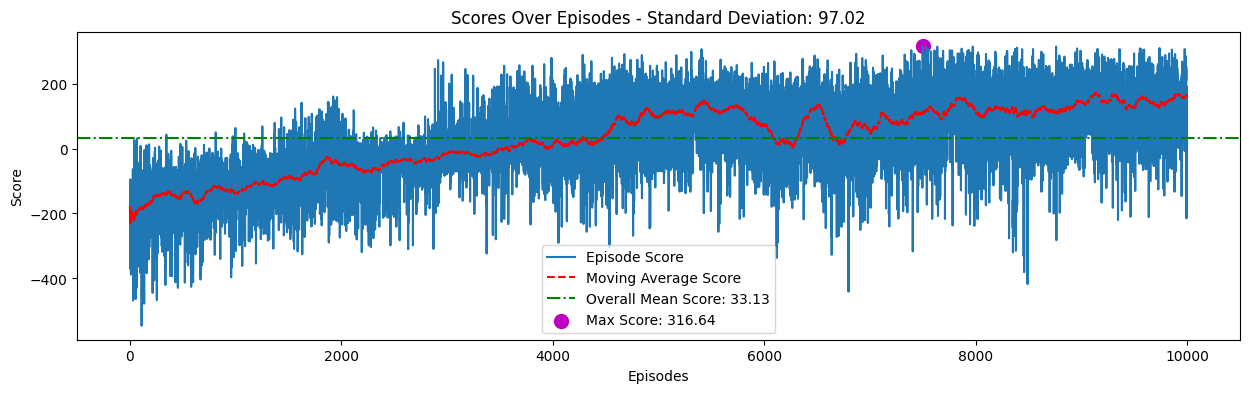

In [18]:
plot_score(score_hist, avg_score_hist, save_path='DQN_1_layer_seed30.png')

if str(device) == "cuda":
    torch.cuda.empty_cache()